In [1]:
pip install git+https://github.com/mwaskom/seaborn.git


  Cloning https://github.com/mwaskom/seaborn.git to /private/var/folders/tz/vjwk136j1mg9xs5sw7m71s8m0000gn/T/pip-req-build-afs1gqxy
  Running command git clone -q https://github.com/mwaskom/seaborn.git /private/var/folders/tz/vjwk136j1mg9xs5sw7m71s8m0000gn/T/pip-req-build-afs1gqxy
  Created wheel for seaborn: filename=seaborn-0.11.0.dev0-cp37-none-any.whl size=254818 sha256=df06752c98998d80596dab182e198bac31d1bdf1f81276af253abcc56d5daff4
  Stored in directory: /private/var/folders/tz/vjwk136j1mg9xs5sw7m71s8m0000gn/T/pip-ephem-wheel-cache-8v5gu7_g/wheels/4e/57/af/138c7bf2390a67f7010588cf080fb8b4e741bb290c2ad12018
Successfully built seaborn
  Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
Note: you may need to restart the kernel to use updated packages.


In [226]:
#For-loop version of Monte Carlo simulation to predict MND diagnosis times
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import kstest
import random
import matplotlib.ticker as ticker
import sys

sns.set_style('whitegrid')

def pathway_simulation(s2gp, delay, gp2neuro, gp2other, neuro2diagnosis, nsim, p1, p2, threshold):
    '''
    #Setting up the distributions for each step. We can change the distribution type, mean and SD. The references
#will dictate what the distributions, mean, SD etc are. 

# UNITS ARE IN DAYS

    Args:
        s2gp (1x3 array): mean, SD and min time taken from symptom onset to presentation to first medical contact
        delay (1x3 array): mean, SD and min time delay in presentation
        gp2neuro (1x3 array): mean, SD and min time taken from gp to neurology appointment
        gp2other (1x3 array): mean, SD and min time taken from gp to other, non-neuro (ortho, ENT etc) appointment
        neuro2diagnosis (1x3 array): mean, SD and min time taken from neurology appointment to diagnosis
        p1 (scalar value): value between 0 and 1 - the probability that patient goes to GP when they have symptoms
        p2 (1x3 array): value between 0 and 1 - the probability that patient is correctly referred to neurologist,
        non-neurologist or not referred at all (should sum to 1)
        nsim (scalar): number of simulation in Monte Carlo simulation
        Threshold (scalar): proportion of people are seen in 'threshold' amount of time

    '''
    
    
    # Set up probability distribution
    #Loc actually sets the minimum of the distribution
    #Shape (alpha) = (mean/SD)**2
    #Scale (beta) = (SD**2)/mean
    symptom_to_gp = gamma(a = (s2gp[0]/s2gp[1])**2, loc = s2gp[2], scale = (s2gp[1]**2)/s2gp[0])
    gp_delay_period = gamma(a = (delay[0]/delay[1])**2, loc = delay[2], scale = (delay[1]**2)/delay[0])
    gp_to_neuro = gamma(a = (gp2neuro[0]/gp2neuro[1])**2, loc = gp2neuro[2], scale = (gp2neuro[1]**2)/gp2neuro[0])
    gp_to_other = gamma(a = (gp2other[0]/gp2other[1])**2, loc = gp2other[2], scale = (gp2other[1]**2)/gp2other[0])
    neuro_to_diagnosis = gamma(a = (neuro2diagnosis[0]/neuro2diagnosis[1])**2, loc = neuro2diagnosis[2], scale = (neuro2diagnosis[1]**2)/neuro2diagnosis[0])

    #Number of simulations
    number_of_simulations = nsim
    
    t = np.arange(0, nsim, 1)
    s2gp_times = np.zeros_like(t, dtype=complex)
    delay_times = np.zeros_like(t, dtype=complex)
    gp2neuro_times = np.zeros_like(t, dtype=complex)
    gp2other_times = np.zeros_like(t, dtype=complex)
    neuro2diagnosis_times = np.zeros_like(t, dtype=complex)
    total_time = np.zeros_like(t, dtype=complex)

    #Simulate the pathway
    for i in t:
    #Generate random number between 0 and 1. Use this number to dictate if patient goes from GP to neuro or other.
        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)
        x = 0
    
    #Symptom onset to GP appointment
        if r1 <= p1: #p1 of people with MND will do straight to the GP
            symptom_to_gp_times = symptom_to_gp.rvs()
            gp_delay_times = 0
        else: 
            symptom_to_gp_times = symptom_to_gp.rvs()
            gp_delay_times = gp_delay_period.rvs()
            
    #GP to referral
        while x < 1:
            if r2 <= p2[0]: #people are referred to neurologist
                gp_to_neuro_times = gp_to_neuro.rvs() #sample from gp2neuro
                gp_to_other_times = 0
                x = 1
            elif p2[0] <= r2 <= p2[0]+p2[1]: #people referred to non-neurologist
                gp_to_other_times = gp_to_other.rvs() #first see a non-neurologist 
                gp_delay_times = gp_delay_times + gp_delay_period.rvs() #then have a delay before going back to the GP
                gp_to_neuro_times = gp_to_neuro.rvs() #then correctly get referred to a neurologist
                x = 1
            elif r2 > p2[0]+p2[1]: #people not referred at all
                gp_delay_times = gp_delay_times + gp_delay_period.rvs() #see GP again with delay
                r2 = random.uniform(0, 1) #pick a new random number for r2
                x = 0 #loops back and patient re-enters GP practice
            
    #Neurology appointment to diagnosis              
        neuro_to_diagnosis_times = neuro_to_diagnosis.rvs()

    #Overall equation for calculating the total time to diagnosis
        s2gp_times[i] = symptom_to_gp_times
        delay_times[i] = gp_delay_times
        gp2neuro_times[i] = gp_to_neuro_times
        gp2other_times[i] = gp_to_other_times
        neuro2diagnosis_times[i] = neuro_to_diagnosis_times
        total_time[i] = symptom_to_gp_times + gp_delay_times + gp_to_neuro_times + gp_to_other_times + neuro_to_diagnosis_times
        
        s2gp_times = s2gp_times.real
        delay_times = delay_times.real
        gp2neuro_times = gp2neuro_times.real
        gp2other_times = gp2other_times.real
        neuro2diagnosis_times = neuro2diagnosis_times.real
        total_time = total_time.real
        
    #Plotting the overall distribution of times taken to go through the clinical pathway
    nbins = 20
    
    fig = plt.figure(figsize=(20,10))
    plt.style.use('seaborn-pastel')
    grid = plt.GridSpec(2, 3, hspace=0.2, wspace=0.2)
    ax1 = fig.add_subplot(grid[0:2, 0])
    ax2 = fig.add_subplot(grid[0, 1])
    ax3 = fig.add_subplot(grid[0, 2])
    ax4 = fig.add_subplot(grid[1, 1])
    ax5 = fig.add_subplot(grid[1, 2]);

    # scatter points on the main axes
    ax1.hist(total_time, nbins)
    ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(total_time)))
    ax2.hist(s2gp_times, nbins)
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(s2gp_times)))
    ax3.hist(gp2neuro_times, nbins)
    ax3.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(gp2neuro_times)))
    ax4.hist(gp2other_times, nbins)
    ax4.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(gp2other_times)))
    ax5.hist(neuro2diagnosis_times, nbins)
    ax5.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(neuro2diagnosis_times)))
    
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Percentage of people')
    ax1.set_title('Total time from symptom onset to diagnosis')
    ax2.set_title('Symptom onset to GP')
    ax3.set_title('GP to Neurology referral')
    ax4.set_title('GP to non-neurology referral')
    ax5.set_title('Neurology appointment to diagnosis')

    #Print valuable information
    print("Proportion of people diagnosed before threshold =",np.mean(total_time < threshold))
    print("Mean time =",np.mean(total_time))
    print("Median time =",np.median(total_time))
    print("Min time =",np.min(total_time))
    
    return total_time

Proportion of people diagnosed before threshold = 0.455
Mean time = 410.85517856231166
Median time = 378.2579497628153
Min time = 147.59611908959977


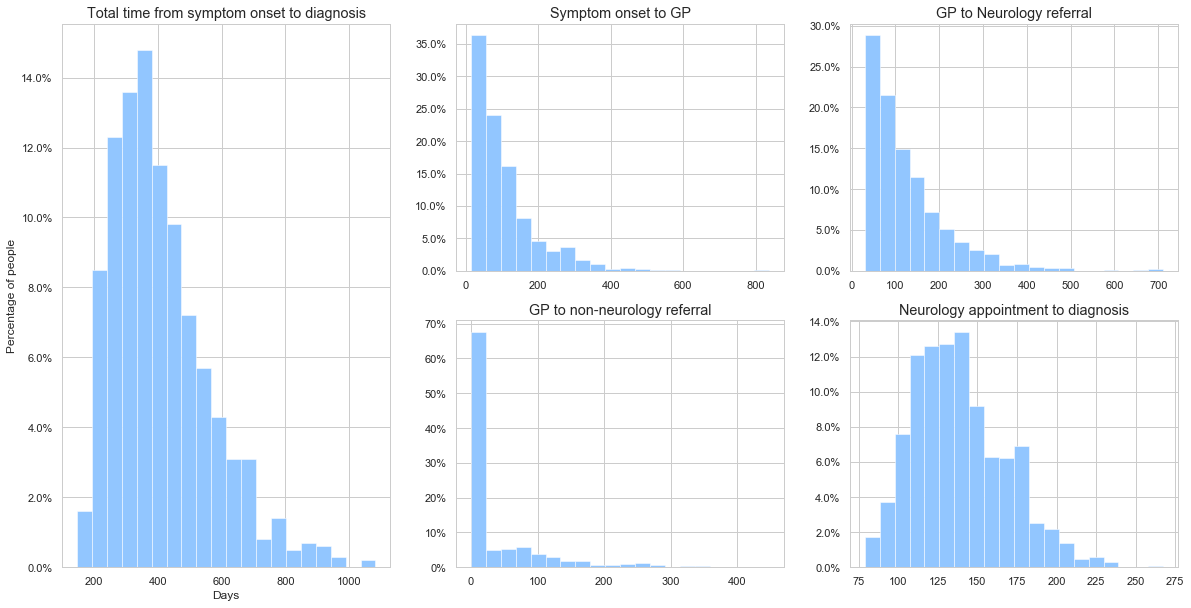

In [228]:
#Pre-COVID model
preCOVID = pathway_simulation([90,90,14], [14,14,1], [90,90,30], [90,90,30], [110,30,30], nsim = 1000, p1 = 0.9, p2 = [0.6,0.3,0.1], threshold = 365)

Proportion of people diagnosed before threshold = 0.0
Mean time = 564.6379705396774
Median time = 531.4888361401365
Min time = 382.39941310918334


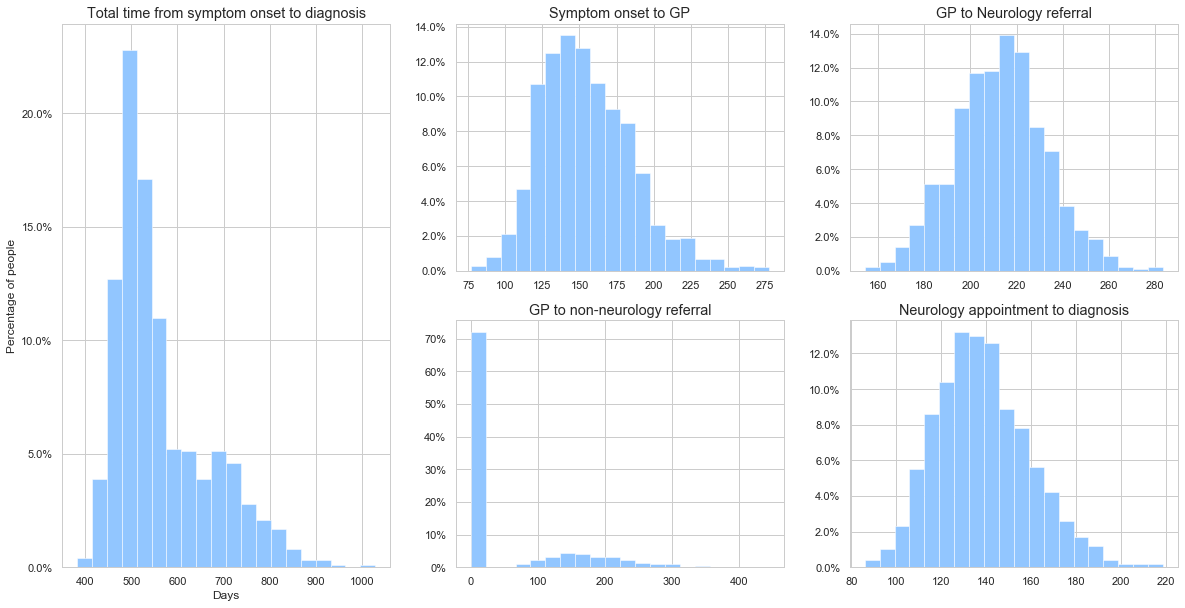

In [206]:
#COVID model
COVID = pathway_simulation([141,30,14], [14,14,1], [182,20,30], [151,60,30], [110,20,30], nsim = 1000, p1 = 0.8, p2 = [0.7,0.25,0.05], threshold = 365)

Min time = 5.606278619745567e-06
81.45284105048404
140.65576852579733
169.08717672729077


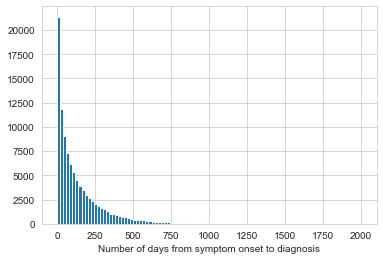

In [23]:
#Changing first paramter in gamma function: 1=exponential function. Increasing this makes the distribution more normal.
#Loc actually sets the minimum of the distribution
#Shape (alpha) = (mean/SD)**2
#Scale (beta) = (SD**2)/mean
s2gp = [141,170]
symptom_to_gp = gamma(a = (s2gp[0]/s2gp[1])**2, loc = 0, scale = (s2gp[1]**2)/s2gp[0])
symptom_to_gp_times = symptom_to_gp.rvs(100000)
print("Min time =",(np.min(symptom_to_gp_times)))
print(np.median(symptom_to_gp_times))
print(np.mean(symptom_to_gp_times))
print(np.std(symptom_to_gp_times))
np.max(symptom_to_gp_times)

plt.hist(symptom_to_gp_times, bins = 100)
plt.xlabel('Number of days from symptom onset to diagnosis')
plt.show()

In [106]:
# https://www.england.nhs.uk/rightcare/wp-content/uploads/sites/40/2019/08/progressive-neuro-toolkit.pdf
# Target: appointments within 4 weeks of referral to a neurologist

TypeError: 'module' object is not callable

In [ ]:
#NEXT STEPS

# Timelines 
#How to work in the bottleneck/binary steps, such as "Do I attend the GP?" and "Whats the probability that my
#makes a referral to the neurologist?".

#One solution is to have a parallel pathway, which deals with the binary (yes,no) nodes. Hence instead of a
#distribution of times to reach diagnosis (as above), we will have a distribution of the number of people that
#remain in the pathway. We can multiply the "time to diagnosis" and "number of people" distributions to see what 
#proportion of people are seen within a certain time. 

#The problem with the above is that the results are representative of one iteration of going through the cycle. 
#Patient's who aren't referred by their GP get worse but inevitably go through the cycle again. The model
#above doesn't account for these returners. We could account for this by using if statements to simulate these 
#different scenarios. For example, we have the initial "Do I go to the GP?" node represented by a Bernoulli (binary)
#distribution with 90% yes and 10% no. In the Monte Carlo simulation, if the simulated person is a 'yes', their 
#GP waiting time distribution is drawn from the distribution above; if the simulated person is a 'no', then their
#GP waiting time is drawn from a 'no' distribution, which has a greater mean than the 'yes' distribution (hence
#simulating a longer waiting time). This can be done for all binary and continuous nodes, which might be a better
#way to simulate the process.

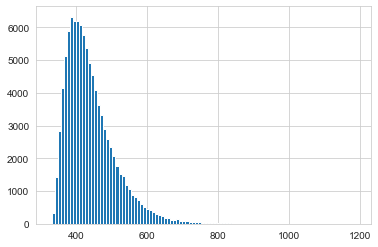

0.83247


In [2]:
#Mock up of Monte Carlo simulation to predict MND diagnosis times
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import kstest

sns.set_style('whitegrid')

def pathway_simulation(s2gp, gp2neuro, neuro2diagnosis, nsim, threshold):
    '''
    #Setting up the distributions for each step. We can change the distribution type, mean and SD. The references
#will dictate what the distributions, mean, SD etc are. 

# UNITS ARE IN DAYS

    Args:
        s2gp (1x2 array): mean and SD of time taken from symptom onset to presentation to first medical contact
        gp2neuro (1x2 array): mean and SD of time taken from gp to neurology appointment
        neuro2diagnosis (1x2 array): mean and SD of time taken from neurology appointment to diagnosis
        nsim (scalar): number of simulation in Monte Carlo simulation
        Threshold (scalar): proportion of people are seen in 'threshold' amount of time

    '''
    # PRECOVID model NEED TO ADJUST THESE AND RENAME
    # Figures from https://www.jns-journal.com/action/showPdf?pii=S0022-510X%2820%2930391-9
    # Based on 64 patients in Barts in 2000
    symptom_to_gp = gamma(1, loc = s2gp[0], scale = s2gp[1]) 
    gp_to_neuro = gamma(1, loc = gp2neuro[0], scale = gp2neuro[1])
    neuro_to_diagnosis = gamma(1, loc = neuro2diagnosis[0], scale = neuro2diagnosis[1])

    #Number of simulations
    number_of_simulations = nsim

    #This is the Monte Carlo simulation bit
    symptom_to_gp_times = symptom_to_gp.rvs(number_of_simulations)
    gp_to_neuro_times = gp_to_neuro.rvs(number_of_simulations)
    neuro_to_diagnosis_times = neuro_to_diagnosis.rvs(number_of_simulations)

    #Put it all together in a dataframe
    data = pd.DataFrame({
        "symptom_to_gp_times": symptom_to_gp_times,
        "gp_to_neuro_times": gp_to_neuro_times,
        "neuro_to_diagnosis_times": neuro_to_diagnosis_times
    })

    #Below is the overall equation for calculating the variable of interest
    data["total_time"] = data.symptom_to_gp_times + data.gp_to_neuro_times + data.neuro_to_diagnosis_times

    #Plotting the overall distribution of times taken to go through the clinical pathway. Note that we can plot each step.
    plt.hist(data.total_time, bins = 100)
    plt.show()

    #gives probability that someone who goes through this pathway is seen in less than 400 days
    print(data[data["total_time"] < threshold].count()["total_time"] / nsim)

    return

peacetime = pathway_simulation([90,30], [180,60],[60,20], nsim = 100000, threshold = 500)